## Load libs

In [1]:
from utils.epg import *
import matplotlib.pyplot as plt
from copy import copy
cmap = copy(plt.cm.get_cmap("jet"))
from scipy.optimize import least_squares

In [2]:
#whenever want to reload libraries
import importlib
import utils
importlib.reload(utils.epg)
from utils.epg import *

In [3]:
degree = r"${}^{\circ}$"
GeV = "GeV"
GeV2 = "GeV"+r"${}^{2}$"
GeVc = "GeV/c"
GeVc2 = "(GeV/c)"+r"${}^{2}$"

In [4]:
import matplotlib
# initial settings
pgf_with_latex = {
		"pgf.texsystem": "pdflatex",
		"text.usetex": True,            # use LaTeX to write all text
		"font.family": "sans-serif",         
		"font.sans-serif": "Helvetica",
		"font.size": 25,				# default font size
		"axes.labelsize": 24,			# x and y label size
		"axes.titlesize": 24,           # subfigure title size, i.e. title size when one figure
		"legend.fontsize": 22,			# legend size
		"xtick.labelsize": 23,			# x axis tick label size
		"ytick.labelsize": 23,			# y axis tick label 
		"figure.titlesize": 25,         # Figure title size, useful when you have multiple plots in one canvas.
		"pgf.preamble": r"\usepackage{xcolor}"     # xcolor for colours
}
matplotlib.rcParams.update(pgf_with_latex)


## Load simulational data

perform momentum corrections that we did at [previous nb](ProtonMomentumCorrection.ipynb).

In [5]:
#pi0 from Andrey, inb, rec
fname = "~/Dropbox (MIT)/data/MC/dnp/pi0DNPInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=True)
dvcs = epg.getDVCS(correction= True, sub2g=False)
pi0MCdnpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_ep": epg.df_ep, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC":epg.df_MC}

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))
axs[0].hist2d(dvpi02.MCPpx, (dvpi02["MCPpx"]-dvpi02["Ppx"])/(dvpi02.MCPpx), bins = [np.linspace(-2, 2, 301), np.linspace(-.25, .25, 301)], cmin = 1, cmap = cmap)
axs[1].hist2d(dvpi02.Ppy, (dvpi02["MCPpy"]-dvpi02["Ppy"])/(dvpi02.MCPpy), bins = [np.linspace(-2, 2, 301), np.linspace(-.25, .25, 301)], cmin = 1, cmap = cmap)
axs[2].hist2d(dvpi02.Ppz, (dvpi02["MCPpz"]-dvpi02["Ppz"])/dvpi02.MCPpz, bins = [np.linspace(-2, 2, 301), np.linspace(-.25, .25, 301)], cmin = 1, cmap = cmap)
# plt.plot(np.linspace(0.25, 4, 101), correction(res_lsq, np.linspace(0.25, 4, 101)), color='k', linewidth=4)
axs[0].set_xlabel(r"$p_x$" + " (rec.) " + "[" + GeV + "]")
axs[0].set_ylabel(r"$\delta p_x/p_x$" )
axs[1].set_xlabel(r"$p_y$" + " (rec.) " + "[" + GeV + "]")
axs[1].set_ylabel(r"$\delta p_y/p_y$" )
axs[2].set_xlabel(r"$p_z$" + " (rec.) " + "[" + GeV + "]")
axs[2].set_ylabel(r"$\delta p_z/p_z$" )
plt.tight_layout()
plt.savefig("correction_direction.pdf")

In [234]:
def fun(x, t, y):
    return x[0]*np.exp(x[1]*t) - y
x0 = np.ones(2)
x0[1] = -4
res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], (dvpi01["MCPpz"]-dvpi01["Ppz"])))

In [231]:
# def correction(res_lsq, t):
#     x0, x1 = res_lsq.x
#     return x0*np.exp(x1*t)
def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.exp(x1*t)

In [7]:
dvpi0 = pi0MCdnpInb["dvpi0"]
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi0["Pp"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], dvpi0["Ppz"]])
dvpi0["MCPpt"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], 0])
dvpi0["Ppt"] = mag([dvpi0["Ppx"], dvpi0["Ppy"], 0])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi02 = dvpi02[np.abs(dvpi02["MCPp"]-dvpi02["Pp"]-correction(res_lsq, dvpi02["Pp"]))<0.02]


In [260]:
# def fun(x, t, y):
#     return x[0]*np.exp(x[1]*t) - y
# x0 = np.ones(2)
# x0[1] = -1
# def fun(x, t, y):
#     return x[0] + x[1]*np.exp(x[2]*t) - y
# x0 = np.ones(3)
# x0[2] = -1
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]<0.1]
# dvpi02 = dvpi02[dvpi02["MCPp"]-dvpi02["Pp"]>-0.025]
# dvpi01 = dvpi01[dvpi01["MCPp"]-dvpi01["Pp"]<0.1]
# dvpi01 = dvpi01[dvpi01["MCPp"]-dvpi01["Pp"]>-0.025]
x0 = [0.1, -4]
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], dvpi01["MCPpz"]-dvpi01["Ppz"]))
    dvpi01 = dvpi01[np.abs(dvpi01["MCPpz"]-dvpi01["Ppz"]-correction(res_lsq, dvpi01["Ppz"]))<0.05]
print(res_lsq.x)

x0 = [0.3, -4]
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi02["Ppz"], dvpi02["MCPpz"]-dvpi02["Ppz"]))
    dvpi02 = dvpi02[np.abs(dvpi02["MCPpz"]-dvpi02["Ppz"]-correction(res_lsq, dvpi02["Ppz"]))<0.05]
print(res_lsq.x)



[ 0.03911681 -2.14861963]
[ 0.12280133 -2.6236946 ]


In [248]:
def correction1(t):
#     x0, x1, x2 = [ 3.13918522*10**(-3),  9.52245629*10**(-2), -4.32347321]

#     return x0 + x1*np.exp(x2*t)
    x0, x1 = [0.0393756,  -2.15849406]
    return x0*np.exp(x1*t)

In [296]:
def correction2(t):
#     x0, x1, x2 = [ 0.00955419,  0.28460921, -5.12699082]
#     return x0 + x1*np.exp(x2*t)
#     x0, x1 = [ 0.2, -3]

    x0, x1 = [ 0.12280133, -2.6236946 ]
#     x0, x1 = [ 0.14562192, -2.88444923]
    return x0*np.exp(x1*t)

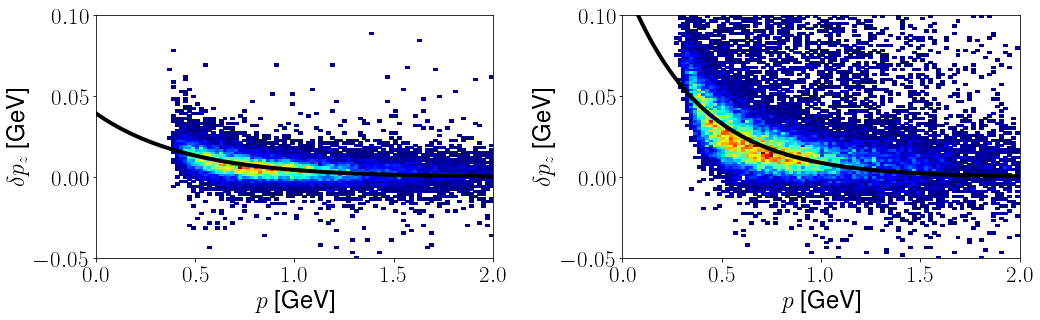

In [297]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi01.Ppz, (dvpi01["MCPpz"]-dvpi01["Ppz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[0].plot(np.linspace(0, 2, 101), correction1(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

ax[1].hist2d(dvpi02.Ppz, (dvpi02["MCPpz"]-dvpi02["Ppz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(0, 2, 101), correction2(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

plt.tight_layout()
# plt.show()
# plt.savefig("correction_answer.pdf")

In [111]:
def correction3(t):
    x = [ 0.008,  2.1932]
    return x[0]*np.sin(t/180*np.pi+x[1])

def correction4(t):
    x = [0.008, 0.6224]
    return x[0]*np.sin(t/180*np.pi+x[1])


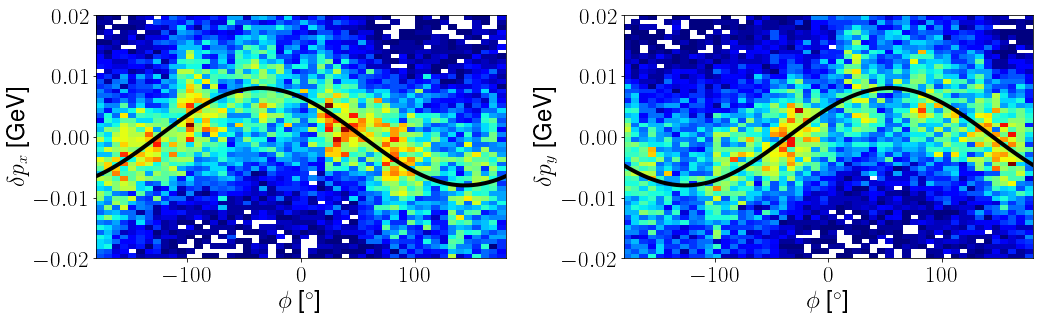

In [116]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi02.Pphi, (dvpi02["MCPpx"]-dvpi02["Ppx"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[0].plot(np.linspace(-180, 180, 101), correction3(np.linspace(-180, 180, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_{x}$"+ " [" + GeV + "]")
ax[0].set_xlabel("$\phi$"+ " [" + degree + "]")

ax[1].hist2d(dvpi02.Pphi, (dvpi02["MCPpy"]-dvpi02["Ppy"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(-180, 180, 101), correction4(np.linspace(-180, 180, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_y$"+ " [" + GeV + "]")
ax[1].set_xlabel("$\phi$"+ " [" + degree + "]")

plt.tight_layout()
# plt.show()
plt.savefig("correction_phi.pdf")

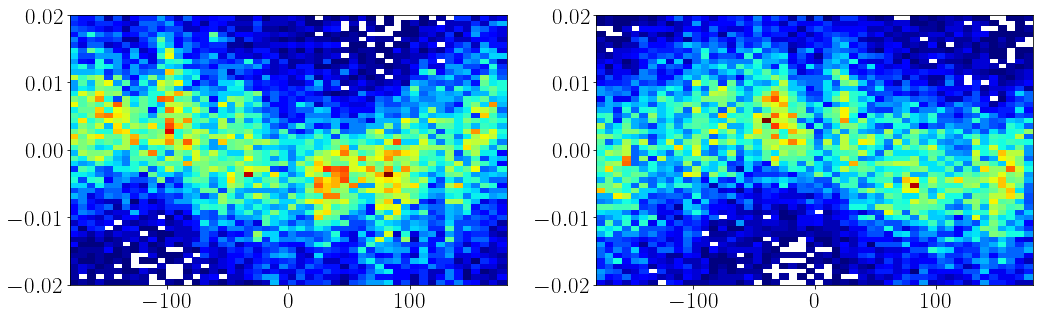

In [204]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi02.Pphi, (dvpi02["MCPpx"]-dvpi02["Ppx"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
# ax[0].plot(np.linspace(-180, 180, 101), correction3(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

ax[1].hist2d(dvpi02.Pphi, (dvpi02["MCPpy"]-dvpi02["Ppy"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(-180, 180, 101), correction4(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

plt.tight_layout()
plt.show()
# plt.savefig("correction_answer.pdf")

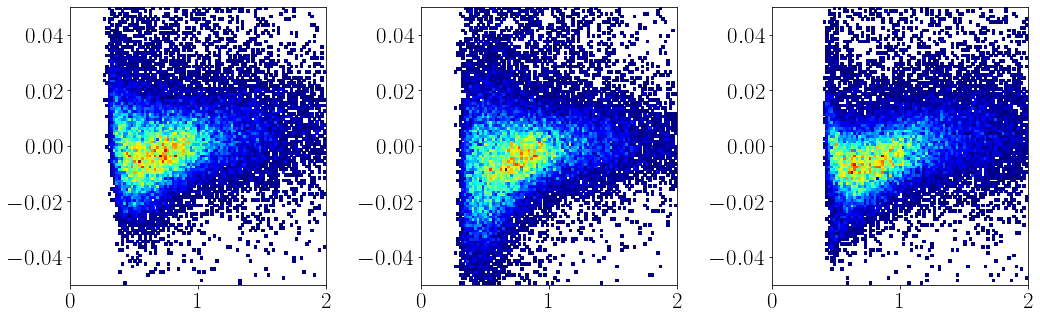

In [306]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Ppz, dvpi02.MCPpz-dvpi02.Ppz-correction2(dvpi02.Ppz), bins = [np.linspace(0,2, 101), np.linspace(-0.05, 0.05, 101)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0,2, 101), 0+np.zeros(101), color='k', linewidth=4)
ax[1].hist2d(dvpi02.Ppz, dvpi02.MCPpt-dvpi02.Ppt-correction2(dvpi02.Ppz)*dvpi02.Ppt/dvpi02.Ppz , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .05, 101)], cmin = 1, cmap = cmap)
ax[2].hist2d(np.sqrt((dvpi02.Ppt+correction2(dvpi02.Ppz)*dvpi02.Ppt/dvpi02.Ppz)**2+dvpi02.Ppz**2), dvpi02.MCPp-np.sqrt((dvpi02.Ppt+correction2(dvpi02.Ppz)*dvpi02.Ppt/dvpi02.Ppz)**2+(dvpi02.Ppz+correction2(dvpi02.Ppz))**2), bins = [np.linspace(0, 2, 101), np.linspace(-.05, .05, 101)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()

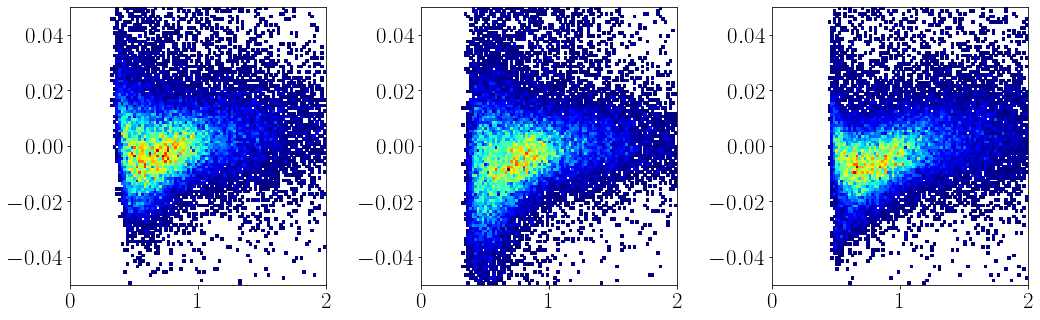

In [8]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Ppz, dvpi02.MCPpz-dvpi02.Ppz, bins = [np.linspace(0,2, 101), np.linspace(-0.05, 0.05, 101)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0,2, 101), 0+np.zeros(101), color='k', linewidth=4)
ax[1].hist2d(dvpi02.Ppz, dvpi02.MCPpt- dvpi02.Ppt , bins = [np.linspace(0, 2, 101), np.linspace(-.05, .05, 101)], cmin = 1, cmap = cmap)
ax[2].hist2d(dvpi02.Pp,  dvpi02.MCPp - dvpi02.Pp, bins = [np.linspace(0, 2, 101), np.linspace(-.05, .05, 101)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()

<AxesSubplot:>

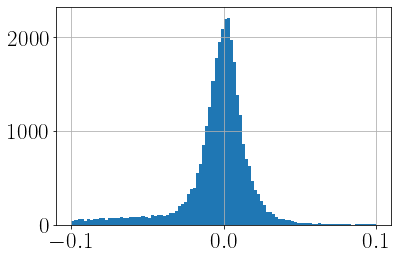

In [215]:
dvpi02cache = dvpi02#[dvpi02.Pp>1]
(dvpi02cache.Ppt + 0.005 - dvpi02cache.MCPpt).hist(bins = np.linspace(-0.1, 0.1 ,101))

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist2d(dvpi02.Pp, dvpi02.MCPpz-dvpi02.Ppz, bins = [np.linspace(0,2, 101), np.linspace(-0.05, 0.05, 101)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0,2, 101), correction(res_lsq, np.linspace(0,2, 101)), color='k', linewidth=4)
ax[1].hist2d(dvpi02.Ppz, np.abs(dvpi02.MCPpt)-np.abs(dvpi02.Ppt), bins = [np.linspace(0, 2, 41), np.linspace(-.05, .05, 41)], cmin = 1, cmap = cmap)
ax[2].hist2d(dvpi02.Pp, dvpi02.MCPp-dvpi02.Pp, bins = [np.linspace(0.4, 2, 51), np.linspace(-.025, .025, 51)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()

In [177]:
def correction(res_lsq, t):
    x0, x1, x2 = res_lsq.x
    x1 = 0.25506579
    return x0 + x1*np.exp(x2*t)

In [184]:
# def fun(x, t, y):
#     return x[0]*np.exp(x[1]*t) - y
# x0 = np.ones(2)
# x0[1] = -1
dvpi02 = dvpi02[dvpi02["MCPpt"]-dvpi02["Ppt"]<0.04]
dvpi02 = dvpi02[dvpi02["MCPpt"]-dvpi02["Ppt"]>-0.02]

def fun(x, t, y):
    return x[0] + x[1]*np.exp(x[2]*t) - y
x0 = [0, 0.28460921, -5.12699082]

# for i in range (0, 100):
res_lsq = least_squares(fun, x0, args=(dvpi02["Ppz"], dvpi02["MCPpt"]-dvpi02["Ppt"]))
#     dvpi02 = dvpi02[np.abs(dvpi02["MCPpt"]-dvpi02["Ppt"]-correction(res_lsq, dvpi02["Pp"]))<0.02]
print(res_lsq.x)



[-1.03405836e-03  1.30883095e-01 -5.01982791e+00]


In [52]:
def fun(x, t, y):
    return x[0]*np.sin(t/180*np.pi+x[1]) - y
x0 = [0.00487466, 2.17733714]

def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.sin(t/180*np.pi + x1)

for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi02["Pphi"], dvpi02["MCPpx"]-dvpi02["Ppx"]))
    dvpi02 = dvpi02[np.abs(dvpi02["MCPpx"]-dvpi02["Ppx"]-correction(res_lsq, dvpi02["Pphi"]))<0.02]
print(res_lsq.x)



[0.01089964 2.17531664]


In [171]:
def fun(x, t, y):
    return x[0]*np.sin(t/180*np.pi+x[1]) - y
x0 = [0.0078204,  0.61706442]

def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.sin(t/180*np.pi + x1)

for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi02["Pphi"], dvpi02["MCPpy"]-dvpi02["Ppy"]))
    dvpi02 = dvpi02[np.abs(dvpi02["MCPpy"]-dvpi02["Ppy"]-correction(res_lsq, dvpi02["Pphi"]))<0.02]
print(res_lsq.x)



[0.01076803 0.63235913]


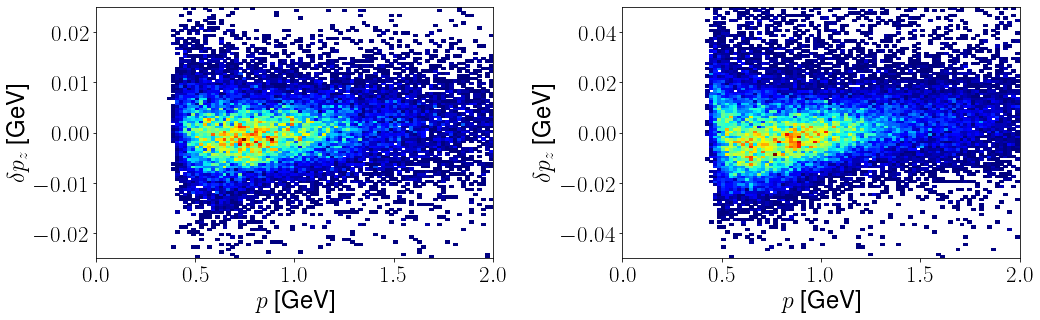

In [298]:
newProz = np.where(dvpi0["Ptheta"]<=27, dvpi0["Ppz"] + correction1(dvpi0["Ppz"]),  dvpi0["Ppz"] + correction2(dvpi0["Ppz"]))
# ratio = newProz/dvpi0["Ppz"]
# newProx = dvpi0["Ppx"].multiply(ratio, axis="index")
# newProy = dvpi0["Ppy"].multiply(ratio, axis="index")
newPro = mag([dvpi0["Ppx"], dvpi0["Ppy"], newProz])
# dvpi0.loc[:,["newPpx"]] = newProx
# dvpi0.loc[:,["newPpy"]] = newProy
dvpi0.loc[:,["newPpz"]] = newProz
dvpi0.loc[:,["newPp"]] = newPro
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

# fig, ax = plt.subplots(1,2, figsize=(15,5))
# ax[0].hist2d(dvpi01.Pp, (dvpi01["MCPp"]-dvpi01["Pp"]), bins = [np.linspace(0,2, 101), np.linspace(-0.25 , 0.25, 101)], cmin = 1, cmap = cmap)
# # ax[0].plot(np.linspace(0, 2, 101), correction1(np.linspace(0, 2, 101)), color='k', linewidth=4)
# ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

# ax[1].hist2d(dvpi02.Pp, (dvpi02["MCPpz"]-dvpi02["Pp"]), bins = [np.linspace(0,2, 101), np.linspace(-0.25 , 0.25, 101)], cmin = 1, cmap = cmap)
# # ax[1].plot(np.linspace(0, 2, 101), correction2(np.linspace(0, 2, 101)), color='k', linewidth=4)
# ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

# plt.tight_layout()
# plt.show()
# # # plt.savefig("correction_answer.pdf")

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvpi01.Ppz, (dvpi01["MCPpz"]-dvpi01["newPpz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.025 , 0.025, 101)], cmin = 1, cmap = cmap)
# ax[0].plot(np.linspace(0, 2, 101), correction1(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

ax[1].hist2d(dvpi02.newPp, (dvpi02["MCPpz"]-dvpi02["newPpz"]), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.05, 101)], cmin = 1, cmap = cmap)
# ax[1].plot(np.linspace(0, 2, 101), correction2(np.linspace(0, 2, 101)), color='k', linewidth=4)
ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

plt.tight_layout()
# plt.show()
# plt.savefig("correction_answer.pdf")

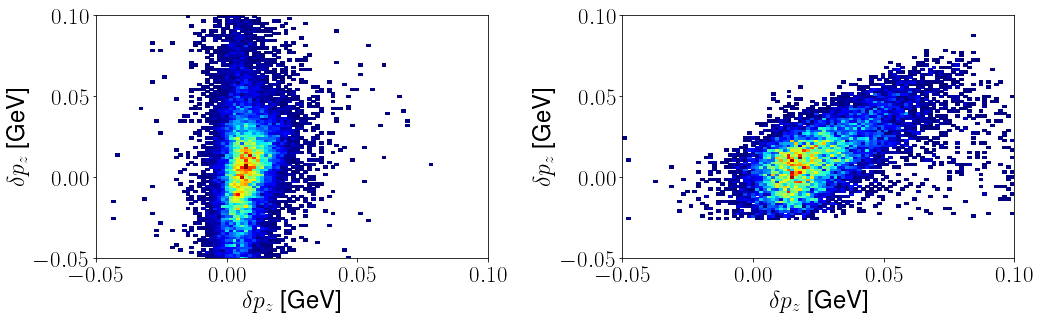

In [792]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d((dvpi01["MCPpz"]-dvpi01["Ppz"]), dvpi01.Pcorrection, bins = [np.linspace(-0.05 , 0.1, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[0].set_xlabel("$\delta p_z$"+ " [" + GeV + "]")
ax[1].hist2d((dvpi02["MCPpz"]-dvpi02["Ppz"]), dvpi02.Pcorrection, bins = [np.linspace(-0.05 , 0.1, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
ax[1].set_xlabel("$\delta p_z$"+ " [" + GeV + "]")

# diff = [(dvpi02["MCPpx"]-dvpi02["Ppx"]), (dvpi02["MCPpy"]-dvpi02["Ppy"]), (dvpi02["MCPpz"]-dvpi02["Ppz"])]
# pro = [dvpi02.loc[:, "Ppx"], dvpi02.loc[:, "Ppy"], dvpi02.loc[:, "Ppz"]]
# plt.hist2d(getPhi(diff), getPhi(pro), bins = [np.linspace(-180, 180, 101), np.linspace(-180, 180, 101)], cmap = cmap, cmin = 1)
# plt.hist(getPhi(pro), bins = 101)
plt.tight_layout()
plt.savefig("correction_correlation.pdf")

In [952]:
# dvcs = dvcsExpInbCorrected["dvcs"]
dvpi0 = pi0MCdnpInb["dvpi0"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvpi0.loc[:, "Ppx"], dvpi0.loc[:, "Ppy"], dvpi0.loc[:, "Ppz"]]
dvpi0.loc[:, "Pp"] = mag(pro)
num = (0.1349768)**2 - dvpi0.MM2_ep
A0 = dvpi0.Ee + dvpi0.Pe - ebeam - M
A3 = dvpi0.Epz + dvpi0.Ppz - pbeam
vecA = [dvpi0["Epx"] + dvpi0["Ppx"], dvpi0["Epy"] + dvpi0["Ppy"], dvpi0["Epz"] + dvpi0["Ppz"] - pbeam]
den = 2*(A0*dvpi0.Pp/dvpi0.Pe - dot(vecA, pro)/mag(pro))
# den = 2 * A0 * dvpi0.Ppz / dvpi0.Pe - 2 * A3
dvpi0.loc[:, "Pcorrection"] = num/den
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<Figure size 432x288 with 0 Axes>

In [178]:
dvpi0 = pi0MCdnpInb["dvpi0"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvpi0.loc[:, "Ppx"], dvpi0.loc[:, "Ppy"], dvpi0.loc[:, "Ppz"]]
dvpi0.loc[:, "Pp"] = mag(pro)
num = (0.1349768)**2 - dvpi0.MM2_ep
A0 = dvpi0.Ee + dvpi0.Pe - ebeam - M
A3 = dvpi0.Epz + dvpi0.Ppz - pbeam
vecA = [dvpi0["Epx"] + dvpi0["Ppx"], dvpi0["Epy"] + dvpi0["Ppy"], dvpi0["Epz"] + dvpi0["Ppz"] - pbeam]
den = 2*(A0*dvpi0.Ppz/dvpi0.Pe - A3)
# den = 2 * A0 * dvpi0.Pp / dvpi0.Pe - 2 * A3
dvpi0.loc[:, "Pcorrection"] = num/den
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [228]:
def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.exp(x1*t)
def fun(x, t, y):
    return x[0]*np.exp(x[1]*t) - y
x0 = np.ones(2)
x0[0] = 0
x0[1] = -1

# def correction(res_lsq, t):
#     x0, x1, x2 = res_lsq.x
#     return x0 + x1*np.exp(x2*t)
# def fun(x, t, y):
#     return x[0] + x[1]*np.exp(x[2]*t) - y
# x0 = np.ones(3)
# x0[0] = 0
# x0[2] = -1

# dvpi02 = dvpi02[dvpi02.Pc<1]
# dvpi02 = dvpi02[dvpi02.Pcorrection<0.1]
# dvpi02 = dvpi02[dvpi02.Pcorrection>-0.025]
dvpi0copy = copy(dvpi02)
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi0copy["Ppz"], dvpi0copy.Pcorrection))
    dvpi0copy = copy(dvpi02[np.abs(dvpi02.Pcorrection-correction(res_lsq, dvpi02["Ppz"]))<0.1])
print(res_lsq.x)

for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], dvpi01.Pcorrection))
    dvpi01 = dvpi01[np.abs(dvpi01.Pcorrection-correction(res_lsq, dvpi01["Ppz"]))<0.11]
print(res_lsq.x)

# def fun(x, t, y):
#     return x[0] + x[1]*np.exp(x[2]*t) - y
# x0 = np.ones(3)
# x0[2] = -1
# for i in range (0, 100):
#     res_lsq = least_squares(fun, x0, args=(dvpi02["Ppz"], dvpi02.Pcorrection))
#     dvpi02 = dvpi02[np.abs(dvpi02.Pcorrection-correction(res_lsq, dvpi02["Ppz"]))<0.02]
# print(res_lsq.x)

AttributeError: 'DataFrame' object has no attribute 'Pcorrection'

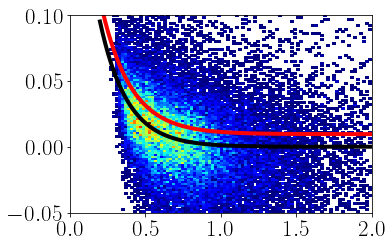

In [180]:
plt.hist2d(dvpi02.Ppz, dvpi02.Pcorrection, bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.Ppz, dvpi02.MCPpz - dvpi02.Ppz, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
plt.plot(np.linspace(0.2, 2, 101), correction(res_lsq, np.linspace(0.2, 2, 101)), color='k', linewidth=4)
plt.plot(np.linspace(0.2, 2, 101), correction2(np.linspace(0.2, 2, 101)), color='r', linewidth=4)
plt.tight_layout()
plt.show()


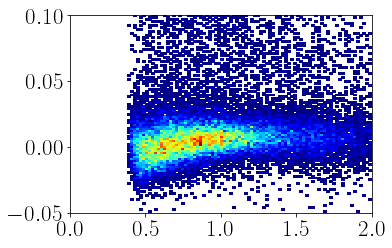

In [37]:
plt.hist2d(dvpi02.Pp, dvpi02.MCPpz - dvpi02.Ppz - correction(res_lsq, dvpi02.Ppz), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.1, 101)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.MCPpz - dvpi02.Ppz, correction2(dvpi02.Ppz), bins = [np.linspace(-0.05 , 0.05, 101), np.linspace(-0.05 , 0.05, 101)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.Ppz, correction(res_lsq, dvpi02.Ppz) - correction2(dvpi02.Ppz), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.02, 101)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()


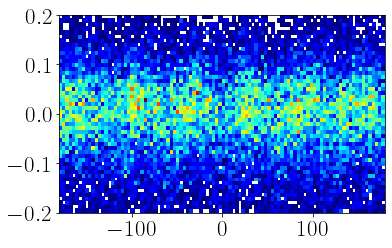

In [131]:
plt.hist2d(dvpi02.Pphi, dvpi02.MM2_ep, bins = [np.linspace(-180,180, 101), np.linspace(-0.2, 0.2, 51)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.MCPpz - dvpi02.Ppz, correction2(dvpi02.Ppz), bins = [np.linspace(-0.05 , 0.05, 101), np.linspace(-0.05 , 0.05, 101)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.Ppz, correction(res_lsq, dvpi02.Ppz) - correction2(dvpi02.Ppz), bins = [np.linspace(0,2, 101), np.linspace(-0.05 , 0.02, 101)], cmin = 1, cmap = cmap)
plt.tight_layout()
plt.show()


## Load experimental data
without any correction, because correction on simulation doesn't guarantee on experiment.

In [85]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/pi0_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(sub2g=False)
pi0ExpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [27]:
#pi0 from experiment, inbending
fname = "~/Dropbox (MIT)/data/data/dvcs_inb.root"
epg = epgFromROOT(fname)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=True)
dvcsExpInb = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg}

In [86]:
dvpi0 = pi0ExpInb["dvpi0"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvpi0.loc[:, "Ppx"], dvpi0.loc[:, "Ppy"], dvpi0.loc[:, "Ppz"]]
dvpi0.loc[:, "Pp"] = mag(pro)
num = (0.1349768)**2 - dvpi0.MM2_ep
A0 = dvpi0.Ee + dvpi0.Pe - ebeam - M
A3 = dvpi0.Epz + dvpi0.Ppz - pbeam
vecA = [dvpi0["Epx"] + dvpi0["Ppx"], dvpi0["Epy"] + dvpi0["Ppy"], dvpi0["Epz"] + dvpi0["Ppz"] - pbeam]
den = 2*(A0*dvpi0.Ppz/dvpi0.Pe - A3)
# den = 2 * A0 * dvpi0.Pp / dvpi0.Pe - 2 * A3
dvpi0.loc[:, "Pcorrection"] = num/den
df_MC = pi0MCdnpInb["df_MC"]
gam1 = df_MC[df_MC.index%2==0]
gam1 = gam1.reset_index(drop=True)
gam2 = df_MC[df_MC.index%2==1]
gam2 = gam2.reset_index(drop=True)
gam1.loc[:,"MCGpx2"] = gam2.loc[:,"MCGpx"]
gam1.loc[:,"MCGpy2"] = gam2.loc[:,"MCGpy"]
gam1.loc[:,"MCGpz2"] = gam2.loc[:,"MCGpz"]
gam1.loc[:,"MCGe2"] = gam2.loc[:,"MCGe"]
df_MC = gam1
dvpi0 = pd.merge(dvpi0, df_MC, how="inner", on="event")
dvpi0copy = copy(dvpi0)
dvpi0copy.loc[:, "MCGe"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe"], dvpi0.loc[:, "MCGe2"])
dvpi0copy.loc[:, "MCGe2"] = np.where(dvpi0["MCGe"]>dvpi0["MCGe2"], dvpi0.loc[:, "MCGe2"], dvpi0.loc[:, "MCGe"])
dvpi0 = dvpi0copy
dvpi0["MCPp"] = mag([dvpi0["MCPpx"], dvpi0["MCPpy"], dvpi0["MCPpz"]])
dvpi01 = dvpi0[dvpi0.Ptheta<27]
dvpi02 = dvpi0[dvpi0.Ptheta>=27]

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [87]:
def correction(res_lsq, t):
    x0, x1 = res_lsq.x
    return x0*np.exp(x1*t)
def fun(x, t, y):
    return x[0]*np.exp(x[1]*t) - y
x0 = np.ones(2)
x0[0] = 0
x0[1] = -1

# def correction(res_lsq, t):
#     x0, x1, x2 = res_lsq.x
#     return x0 + x1*np.exp(x2*t)
# def fun(x, t, y):
#     return x[0] + x[1]*np.exp(x[2]*t) - y
# x0 = np.ones(3)
# x0[0] = 0
# x0[2] = -1

# dvpi02 = dvpi02[dvpi02.Pc<1]
# dvpi02 = dvpi02[dvpi02.Pcorrection<0.1]
# dvpi02 = dvpi02[dvpi02.Pcorrection>-0.025]
dvpi0copy = copy(dvpi02)
for i in range (0, 100):
    res_lsq = least_squares(fun, x0, args=(dvpi0copy["Pp"], dvpi0copy.Pcorrection))
    dvpi0copy = copy(dvpi02[np.abs(dvpi02.Pcorrection-correction(res_lsq, dvpi02["Pp"]))<0.02])
print(res_lsq.x)

# for i in range (0, 100):
#     res_lsq = least_squares(fun, x0, args=(dvpi01["Ppz"], dvpi01.Pcorrection))
#     dvpi01 = dvpi01[np.abs(dvpi01.Pcorrection-correction(res_lsq, dvpi01["Ppz"]))<0.01]
# print(res_lsq.x)

# def fun(x, t, y):
#     return x[0] + x[1]*np.exp(x[2]*t) - y
# x0 = np.ones(3)
# x0[2] = -1
# for i in range (0, 100):
#     res_lsq = least_squares(fun, x0, args=(dvpi02["Ppz"], dvpi02.Pcorrection))
#     dvpi02 = dvpi02[np.abs(dvpi02.Pcorrection-correction(res_lsq, dvpi02["Ppz"]))<0.02]
# print(res_lsq.x)

[ 0.32322679 -4.36995592]


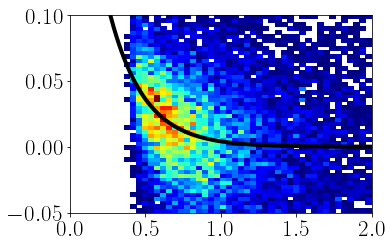

In [88]:
plt.hist2d(dvpi02.Pp, dvpi02.Pcorrection, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
# plt.hist2d(dvpi02.Ppz, dvpi02.MCPpz - dvpi02.Ppz, bins = [np.linspace(0,2, 51), np.linspace(-0.05 , 0.1, 51)], cmin = 1, cmap = cmap)
plt.plot(np.linspace(0.2, 2, 101), correction(res_lsq, np.linspace(0.2, 2, 101)), color='k', linewidth=4)
# plt.plot(np.linspace(0.2, 2, 101), correction2(np.linspace(0.2, 2, 101)), color='r', linewidth=4)
plt.tight_layout()
plt.show()


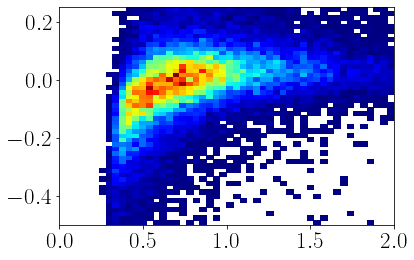

In [105]:
plt.hist2d(dvpi02.Ppz, dvpi02.MM2_ep, bins = [np.linspace(0,2, 51), np.linspace(-0.5 , 0.25, 51)], cmin = 1, cmap = cmap)
# dvpi02.MM2_ep.hist(bins=np.linspace(-0.25 , 0.25, 101))
plt.show()

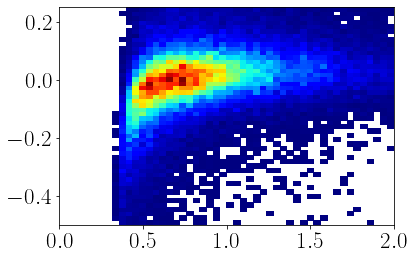

In [108]:
dvpi0copy = copy(dvpi0) 
dvpi0copy.loc[:, "Ppz"] = dvpi0copy.loc[:, "Ppz"] + 0.28674313*np.exp( -5.52191624 * dvpi0copy.loc[:, "Ppz"])
pro = [dvpi0copy['Ppx'], dvpi0copy['Ppy'], dvpi0copy['Ppz']]
dvpi0copy.loc[:, "Pe"] = getEnergy(pro, M)
Vmiss = [-(dvpi0copy["Epx"] + dvpi0copy["Ppx"] + dvpi0copy["Gpx"]), -(dvpi0copy["Epy"] + dvpi0copy["Ppy"] + dvpi0copy["Gpy"]),
         -(-pbeam + dvpi0copy["Epz"] + dvpi0copy["Ppz"] + dvpi0copy["Gpz"])]
dvpi0copy.loc[:,'MM2_epg'] = (-M - ebeam + dvpi0copy["Ee"] +
                     dvpi0copy["Pe"] + dvpi0copy["Ge"])**2 - mag2(Vmiss)
plt.hist2d(dvpi0copy.Ppz, dvpi0copy.MM2_ep, bins = [np.linspace(0,2, 51), np.linspace(-0.5 , 0.25, 51)], cmin = 1, cmap = cmap)
# dvpi0copy.MM2_ep.hist(bins=np.linspace(-0.25 , 0.25, 101))
plt.show()

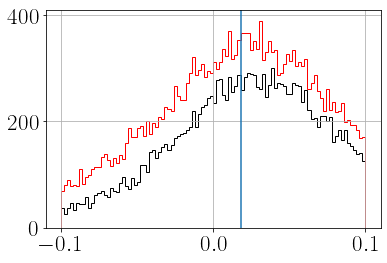

In [16]:
dvpi01.MM2_ep.hist(bins=np.linspace(-0.1 , 0.1, 101), histtype='stepfilled', edgecolor ='k', facecolor='none')
dvpi02.MM2_ep.hist(bins=np.linspace(-0.1 , 0.1, 101), histtype='stepfilled', edgecolor ='r', facecolor='none')
plt.axvline(0.135**2)

In [20]:
#dvcs from simulation, vz correct, vxvy (0, 0), rec
fname = "~/Dropbox (MIT)/data/MC/nonradVzCorrInbREC.root"
epg = epgFromROOT(fname, rec=True)
dvpi0 = epg.getDVpi0(correction=False)
dvcs = epg.getDVCS(correction=False, sub2g=False)
dvcsMCInbCorrected = {"fname":fname, "epg": epg, "dvpi0": dvpi0, "dvcs": dvcs, "df_epg": epg.df_epg, "df_epgg": epg.df_epgg, "df_MC": epg.df_MC}

In [21]:
# dvcs = dvcsExpInbCorrected["dvcs"]
dvpi0 = dvcsMCInbCorrected["dvcs"]
# dvpi0 = dvpi0[dvpi0.Pp<1]
pro = [dvcs.loc[:, "Ppx"], dvcs.loc[:, "Ppy"], dvcs.loc[:, "Ppz"]]
df_MC = dvcsMCInbCorrected["df_MC"]
dvcs = pd.merge(dvcs, df_MC, how="inner", on="event")
dvcscopy = copy(dvcs)
dvcs = dvcscopy
dvcs["MCPp"] = mag([dvcs["MCPpx"], dvcs["MCPpy"], dvcs["MCPpz"]])
dvcs1 = dvcs[dvcs.Ptheta<27]
dvcs2 = dvcs[dvcs.Ptheta>=27]

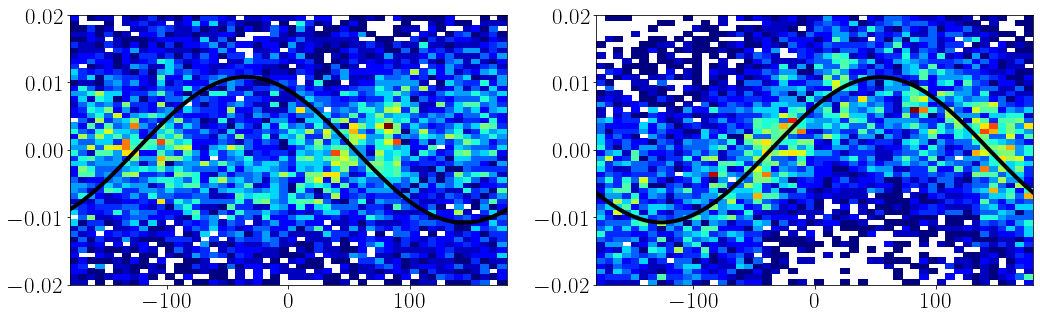

In [23]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].hist2d(dvcs2.Pphi, (dvcs2["MCPpx"]-dvcs2["Ppx"]-correction3(dvcs2["Pphi"])), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[0].plot(np.linspace(-180, 180, 101), correction3(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[0].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[0].set_xlabel("$p$"+ " [" + GeV + "]")

ax[1].hist2d(dvcs2.Pphi, (dvcs2["MCPpy"]-dvcs2["Ppy"]), bins = [np.linspace(-180 , 180, 51), np.linspace(-0.02 , 0.02, 51)], cmin = 1, cmap = cmap)
ax[1].plot(np.linspace(-180, 180, 101), correction4(np.linspace(-180, 180, 101)), color='k', linewidth=4)
# ax[1].set_ylabel("$\delta p_z$"+ " [" + GeV + "]")
# ax[1].set_xlabel("$p$"+ " [" + GeV + "]")

plt.tight_layout()
# plt.show()
# plt.savefig("correction_answer.pdf")